# Load the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/My Drive/website_wata.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())

# Display the first few rows of the dataset
print("\nFirst 5 Rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Page Views        2000 non-null   int64  
 1   Session Duration  2000 non-null   float64
 2   Bounce Rate       2000 non-null   float64
 3   Traffic Source    2000 non-null   object 
 4   Time on Page      2000 non-null   float64
 5   Previous Visits   2000 non-null   int64  
 6   Conversion Rate   2000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 109.5+ KB
None

First 5 Rows:
   Page Views  Session Duration  Bounce Rate Traffic Source  Time on Page  \
0           5         11.051381     0.230652        Organic      3.890460   
1           4          3.429316     0.391001         Social      8.478174   
2           4          1.621052     0.397986        Organic      9.636170   
3           5          3.629279     0.180458        Organic      

# Clean and Transform Data

In [3]:
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

# Fill or drop missing values
numeric_columns = ['Page Views', 'Session Duration', 'Bounce Rate', 'Time on Page', 'Previous Visits', 'Conversion Rate']
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Check for duplicate rows
print("\nDuplicate Rows:", data.duplicated().sum())

# Drop duplicate rows if any
data = data.drop_duplicates()

# Convert Traffic Source to a consistent format
data['Traffic Source'] = data['Traffic Source'].str.strip().str.title()

# Derive new features
data['Engagement Score'] = data['Page Views'] * data['Session Duration']

# Display the cleaned data
print("\nCleaned Data Sample:")
print(data.head())

Missing Values:
Page Views          0
Session Duration    0
Bounce Rate         0
Traffic Source      0
Time on Page        0
Previous Visits     0
Conversion Rate     0
dtype: int64

Duplicate Rows: 0

Cleaned Data Sample:
   Page Views  Session Duration  Bounce Rate Traffic Source  Time on Page  \
0           5         11.051381     0.230652        Organic      3.890460   
1           4          3.429316     0.391001         Social      8.478174   
2           4          1.621052     0.397986        Organic      9.636170   
3           5          3.629279     0.180458        Organic      2.071925   
4           5          4.235843     0.291541           Paid      1.960654   

   Previous Visits  Conversion Rate  Engagement Score  
0                3              1.0         55.256906  
1                0              1.0         13.717263  
2                2              1.0          6.484208  
3                3              1.0         18.146395  
4                5              1

# Load the Data into an SQL Database

In [4]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('website_traffic.db')  # Creates a database file named 'website_traffic.db'

# Load the data into the database
data.to_sql('traffic_data', conn, if_exists='replace', index=False)

# Verify that the data is loaded
cursor = conn.cursor()
cursor.execute("SELECT * FROM traffic_data LIMIT 5")  # Retrieve the first 5 rows
rows = cursor.fetchall()

# Display the retrieved rows
print("\nSample Rows from the Database:")
for row in rows:
    print(row)

# Close the connection
conn.close()


Sample Rows from the Database:
(5, 11.051381236591851, 0.230651936613825, 'Organic', 3.890460070474997, 3, 1.0, 55.256906182959256)
(4, 3.429315699032408, 0.3910013338541704, 'Social', 8.478174486998954, 0, 1.0, 13.717262796129631)
(4, 1.621052045863385, 0.3979861064942929, 'Organic', 9.636169627400935, 2, 1.0, 6.48420818345354)
(5, 3.6292789551861424, 0.180457684705222, 'Organic', 2.071924676446509, 3, 1.0, 18.146394775930712)
(5, 4.235843279057931, 0.2915408735093031, 'Paid', 1.9606538296835625, 5, 1.0, 21.179216395289654)


# Analyze the Data

## Traffic Distribution by Source
- Analyze which traffic sources contribute the most to overall sessions

In [5]:
# Reconnect to the database
conn = sqlite3.connect('website_traffic.db')

# Query: Traffic distribution by source
query = """
SELECT
    "Traffic Source",
    COUNT(*) AS Total_Sessions,
    AVG("Session Duration") AS Avg_Session_Duration
FROM traffic_data
GROUP BY "Traffic Source"
ORDER BY Total_Sessions DESC;
"""

# Execute the query and display results
traffic_distribution = pd.read_sql_query(query, conn)
print("Traffic Distribution by Source:")
print(traffic_distribution)

# Close the connection
conn.close()

Traffic Distribution by Source:
  Traffic Source  Total_Sessions  Avg_Session_Duration
0        Organic             786              3.104197
1           Paid             428              2.942816
2       Referral             301              3.125496
3         Social             269              3.057273
4         Direct             216              2.692060


## Average Bounce Rate by Traffic Source
- Understand which sources lead to higher or lower bounce rates

In [6]:
# Reconnect to the database
conn = sqlite3.connect('website_traffic.db')

# Query: Average bounce rate by traffic source
query = """
SELECT
    "Traffic Source",
    AVG("Bounce Rate") AS Avg_Bounce_Rate
FROM traffic_data
GROUP BY "Traffic Source"
ORDER BY Avg_Bounce_Rate ASC;
"""

# Execute the query and display results
bounce_rate_analysis = pd.read_sql_query(query, conn)
print("\nAverage Bounce Rate by Traffic Source:")
print(bounce_rate_analysis)

# Close the connection
conn.close()


Average Bounce Rate by Traffic Source:
  Traffic Source  Avg_Bounce_Rate
0       Referral         0.266305
1        Organic         0.281821
2         Direct         0.284581
3           Paid         0.296026
4         Social         0.296265


## High-Engagement Pages
- Find pages with the highest Engagement Score (Page Views × Session Duration)

In [7]:
# Reconnect to the database
conn = sqlite3.connect('website_traffic.db')

# Query: Pages with the highest engagement
query = """
SELECT
    "Page Views",
    "Session Duration",
    "Engagement Score",
    "Traffic Source"
FROM traffic_data
ORDER BY "Engagement Score" DESC
LIMIT 10;
"""

# Execute the query and display results
high_engagement_pages = pd.read_sql_query(query, conn)
print("\nHigh Engagement Pages:")
print(high_engagement_pages)

# Close the connection
conn.close()


High Engagement Pages:
   Page Views  Session Duration  Engagement Score Traffic Source
0          10         14.807055        148.070548           Paid
1           8         18.160452        145.283615         Social
2          10         14.337776        143.377764        Organic
3          10         13.848628        138.486278        Organic
4           8         16.676578        133.412624        Organic
5           6         19.143636        114.861817        Organic
6           6         18.336680        110.020078       Referral
7          11          9.644907        106.093981        Organic
8           9         11.412671        102.714035        Organic
9           7         14.305782        100.140475           Paid


# Data Visualizations

## Traffic Distribution by Source
- Visualize the total sessions and average session duration for each traffic source using bar charts

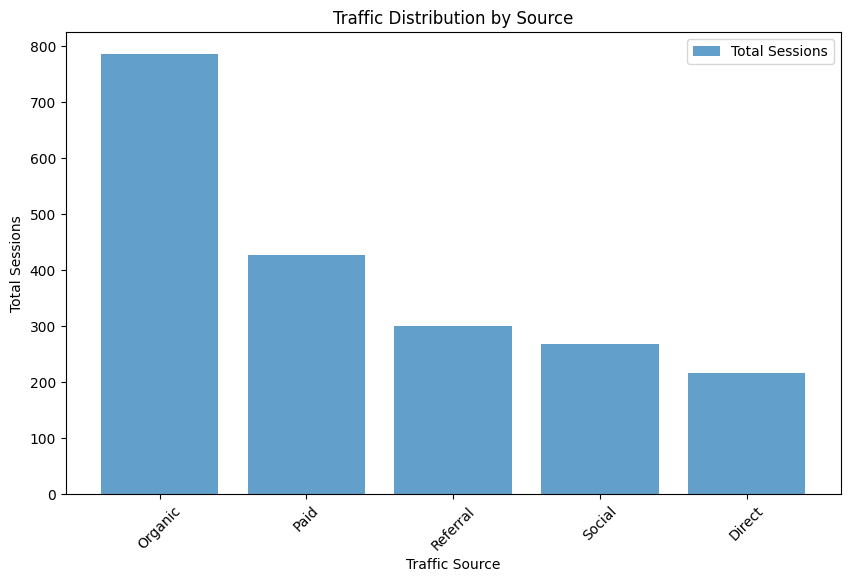

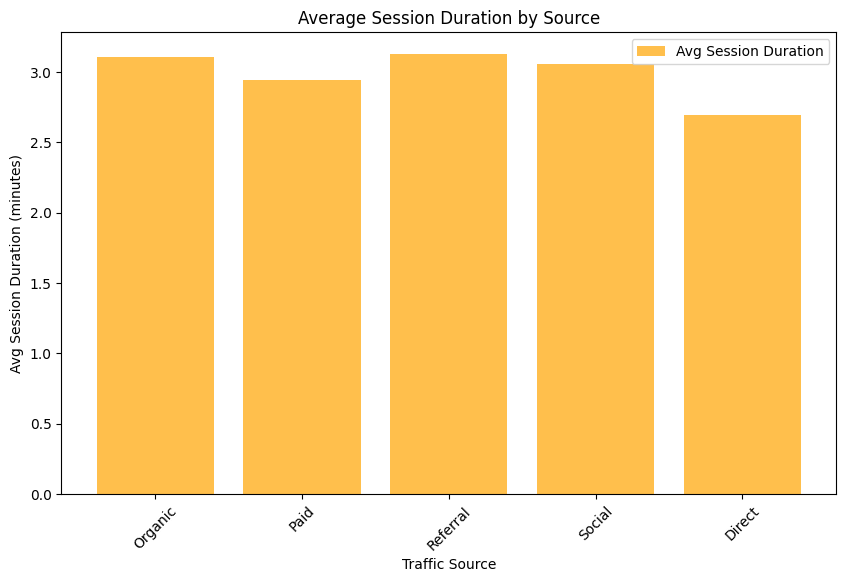

In [8]:
import matplotlib.pyplot as plt

# Plot: Total Sessions by Traffic Source
plt.figure(figsize=(10, 6))
plt.bar(traffic_distribution['Traffic Source'], traffic_distribution['Total_Sessions'], alpha=0.7, label='Total Sessions')
plt.title('Traffic Distribution by Source')
plt.xlabel('Traffic Source')
plt.ylabel('Total Sessions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot: Average Session Duration by Traffic Source
plt.figure(figsize=(10, 6))
plt.bar(traffic_distribution['Traffic Source'], traffic_distribution['Avg_Session_Duration'], color='orange', alpha=0.7, label='Avg Session Duration')
plt.title('Average Session Duration by Source')
plt.xlabel('Traffic Source')
plt.ylabel('Avg Session Duration (minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Average Bounce Rate by Traffic Source
- Plot a bar chart to highlight differences in bounce rates

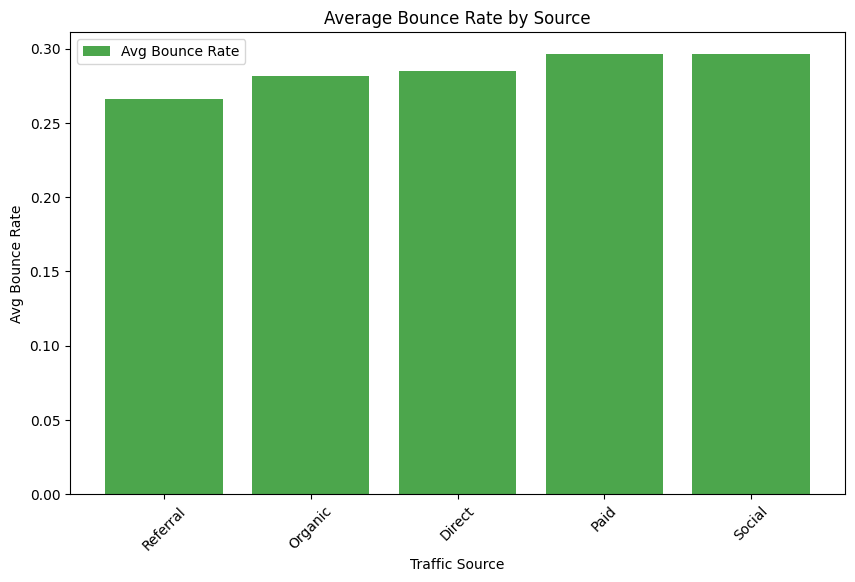

In [9]:
# Plot: Average Bounce Rate by Traffic Source
plt.figure(figsize=(10, 6))
plt.bar(bounce_rate_analysis['Traffic Source'], bounce_rate_analysis['Avg_Bounce_Rate'], color='green', alpha=0.7, label='Avg Bounce Rate')
plt.title('Average Bounce Rate by Source')
plt.xlabel('Traffic Source')
plt.ylabel('Avg Bounce Rate')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## High Engagement Pages
- Create a scatter plot to analyze the relationship between Page Views, Session Duration, and Engagement Score

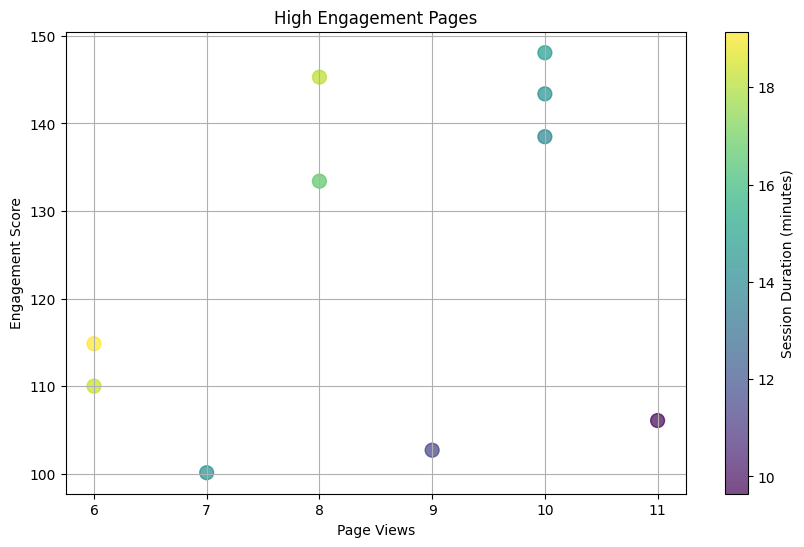

In [10]:
# Scatter Plot: High Engagement Pages
plt.figure(figsize=(10, 6))
plt.scatter(high_engagement_pages['Page Views'], high_engagement_pages['Engagement Score'], c=high_engagement_pages['Session Duration'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Session Duration (minutes)')
plt.title('High Engagement Pages')
plt.xlabel('Page Views')
plt.ylabel('Engagement Score')
plt.grid(True)
plt.show()

## Insights and Recommendations

### 1. Traffic Distribution
- **Insight**: Organic traffic contributes the highest number of sessions (786), followed by Paid (428) and Referral (301). Direct traffic has the lowest number of sessions (216).
- **Recommendation**:
  - Focus on maintaining and enhancing **SEO strategies** to further capitalize on Organic traffic.
  - Explore opportunities to increase Paid and Referral traffic through optimized campaigns and partnerships.

### 2. Average Session Duration
- **Insight**: Referral traffic has the highest average session duration (3.13 minutes), followed closely by Organic (3.10 minutes) and Social (3.06 minutes). Direct traffic has the lowest session duration (2.69 minutes).
- **Recommendation**:
  - Strengthen **partnerships with referral sources** to increase high-quality traffic.
  - Investigate ways to improve user experience for Direct traffic to encourage longer sessions.

### 3. Bounce Rate
- **Insight**: Referral traffic has the lowest average bounce rate (26.63%), while Social and Paid traffic have slightly higher bounce rates (~29.6%).
- **Recommendation**:
  - **Optimize landing pages** for Social and Paid campaigns to reduce bounce rates. Ensure page content aligns with user expectations and loads quickly.

### 4. High Engagement Pages
- **Insight**: Pages with high engagement scores (>100) are primarily associated with Organic and Paid traffic sources. The top page has an engagement score of 148.07 (Paid traffic).
- **Recommendation**:
  - Analyze the design and content of high-engagement pages and replicate successful elements across other pages.
  - Use **A/B testing** to refine Paid traffic campaigns and further increase engagement.

